<a href="https://colab.research.google.com/github/fisherj1/Neural/blob/master/Lesson7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Embedding, Concatenate, Input, BatchNormalization
from tensorflow.compat.v1.train import AdamOptimizer
from tensorflow.keras.initializers import RandomNormal

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")
try:
  logical_gpus = tf.config.experimental.list_logical_devices("GPU")
  print(f"Physical GPUs {len(gpus)}\nLogical GPUs {len(logical_gpus)}")
except RuntimeError as e:
  print(e)

Physical GPUs 1
Logical GPUs 1


In [ ]:
def create_discriminator(in_shape=(28,28,1), n_classes=10):
    in_label = Input(shape=(1,))  # input layer
    li = Embedding(n_classes, 50)(in_label)  # embedding for categorical input
    n_nodes = in_shape[0] * in_shape[1]  # scale up to image dimensions
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    in_image = Input(shape=in_shape)  # image input
    merge = Concatenate()([in_image, li])
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same',
                activation=LeakyReLU(alpha=0.2)
                )(merge)  # downsample
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same',
                activation=LeakyReLU(alpha=0.2)
                )(fe)
    fe = Flatten()(fe)  # Flatten feature maps
    fe = Dropout(0.4)(fe)  # Regularization via dropout
    out_layer = Dense(1, activation='sigmoid')(fe)  # Output
    
    model = Model([in_image, in_label], out_layer)  # Creating model
    model.compile(optimizer=AdamOptimizer(learning_rate=0.0002, beta1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def create_generator(latent_dim=100, n_classes=10):
    in_label = Input(shape=(1,))  # label input
    li = Embedding(n_classes, 50)(in_label) # embedding for categorical input
    n_nodes = 7*7  # linear multiplication
    li = Dense(n_nodes)(li)
    li = Reshape((7, 7, 1))(li)
    in_lat = Input(shape=(latent_dim,))  # image generator input
    
    n_nodes = 128*7*7  # foundation for 7x7 image
    gen = Dense(n_nodes, activation=LeakyReLU(alpha=0.2))(in_lat)
    gen = Reshape((7, 7, 128))(gen)
    merge = Concatenate()([gen, li])  # merge image gen and label input
    
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(3,3),
                          strides=(2,2),
                          padding='same',
                          activation=LeakyReLU(alpha=0.2)
                          )(merge)  # upsampling to 14x14
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(3,3),
                          strides=(2,2),
                          padding='same',
                          activation=LeakyReLU(alpha=0.2)
                          )(gen)  # updampling to 28x28
    out_layer = Conv2D(filters=1,
                       kernel_size=(7,7),
                       activation='tanh',
                       padding='same'
                       )(gen)  # output
    model = Model([in_lat, in_label], out_layer)  # define model
    return model

In [ ]:
def create_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # get noise and label inputs from generator
    gen_noise, gen_label = generator.input
    # get image output from the generator model
    gen_output = generator.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = discriminator([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    model.compile(loss='binary_crossentropy', optimizer=AdamOptimizer(learning_rate=0.0002, beta1=0.5))
    return model

In [ ]:
def load_real_data(dataset):
    # Loading data
    (X_train, y_train), (X_test, y_test) = dataset.load_data()
    # We don't need separate test data so we can add it to our training data
    X_train = np.concatenate((X_train, X_test), axis=0)
    y_train = np.concatenate((y_train, y_test), axis=0)
    # Conv2D awaits 3-dimensional input data (color channel) so, we must add 1 axis
    X_train = np.expand_dims(X_train, axis=-1)
    # Rescale our data from [0, 255] to [-1,1]
    X_train = X_train.astype('float32')
    X_train = (X_train - 127.5) / 127.5
    return [X_train, y_train]

In [ ]:
def gen_real_batch(dataset, n_samples):
    X_train, y_train = dataset
    # Generate n random indexes
    ix = np.random.randint(0, X_train.shape[0], n_samples)
    # Select n random images from our imageset
    X = X_train[ix]
    labels = y_train[ix]
    y = np.ones(n_samples)
    #print(y)
    return [X, labels], y

In [ ]:
# Create n random latent-space vectors
def gen_latent_vecs(n_samples, latent_dim=100, n_classes=10):
    latent_vecs = np.random.normal(0, 1, [n_samples, latent_dim])
    labels = np.random.randint(0, n_classes, n_samples)
    return [latent_vecs, labels]

In [ ]:
def gen_fake_batch(generator, n_samples, latent_dim=100, n_classes=10):
    [latent_vecs, labels] = gen_latent_vecs(n_samples, latent_dim, n_classes)
    X = generator.predict([latent_vecs, labels])
    y = np.zeros(n_samples)
    #print(y)
    return [X, labels], y

In [ ]:
def gen_train_batch(generator, dataset, batch_size, latent_dim=100, n_classes=10):
    half_batch_size = batch_size // 2
    # Get a half batch of real samples
    [X_real, real_labels], y_real = gen_real_batch(dataset, half_batch_size)
    # Get a half batch of fake samples
    [X_fake, fake_labels], y_fake = gen_fake_batch(generator, half_batch_size, \
                                                   latent_dim, n_classes)
    # Make a mixed batch
    #X_fake = np.reshape(X_fake, (-1, 28, 28))
    X = np.concatenate((X_real, X_fake), axis=0)
    y = np.concatenate((y_real, y_fake), axis=0)
    labels = np.concatenate((real_labels, fake_labels), axis=0)
    # Shuffle real and fake images
    shuffle = np.random.randint(0, batch_size, batch_size)
    X = X[shuffle]
    y = y[shuffle]
    labels = labels[shuffle]
    return [X, labels], y

In [ ]:
def print_generated_images(generator, h, w, latent_dim=100):
    n = h*w
    X, _ = gen_latent_vecs(n, latent_dim)
    labels = np.asarray([x for _ in range(h) for x in range(w)])
    y_p = generator.predict([X, labels])

    fig = plt.figure(figsize=(20,10))
    for i in range(n):
        plt.subplot(h, w, 1 + i)
        plt.axis('off')
        plt.title("label: {}".format(labels[i]))
        plt.imshow(y_p[i, :, :, 0], cmap='gray_r')
    plt.show()

In [ ]:
def train(generator, discriminator, gan, dataset, latent_dim, n_epoches=100, \
          batch_size=128, n_classes=10):
    X_train, y_train = dataset
    n_batches = X_train.shape[0] // batch_size
    half_batch_size = batch_size // 2

    for i in range(n_epoches):
        for j in range(n_batches):
            # Train discriminator
            [X_d, labels_d], y_d = gen_train_batch(generator, dataset, \
                                                   batch_size, latent_dim)
            d_loss, d_acc = discriminator.train_on_batch([X_d, labels_d], y_d)
            # Train generator
            [X_gan, labels] = gen_latent_vecs(batch_size, latent_dim)
            y_gan = np.ones(batch_size)
            g_loss = gan.train_on_batch([X_gan, labels], y_gan)

            print('\rEpoch: >%d, Batch: %d/%d, Dis_loss=%.3f, Dis_accuracy=%.3f Gen_loss=%.3f' % (i+1, j+1, n_batches, d_loss, d_acc, g_loss), end='')
        print()
        if i == 0 or i == 1 or (i+1) % 20 == 0:
            print_generated_images(generator, 4, 10, latent_dim)

Epoch: >1, Batch: 546/546, Dis_loss=0.665, Dis_accuracy=0.602 Gen_loss=0.739


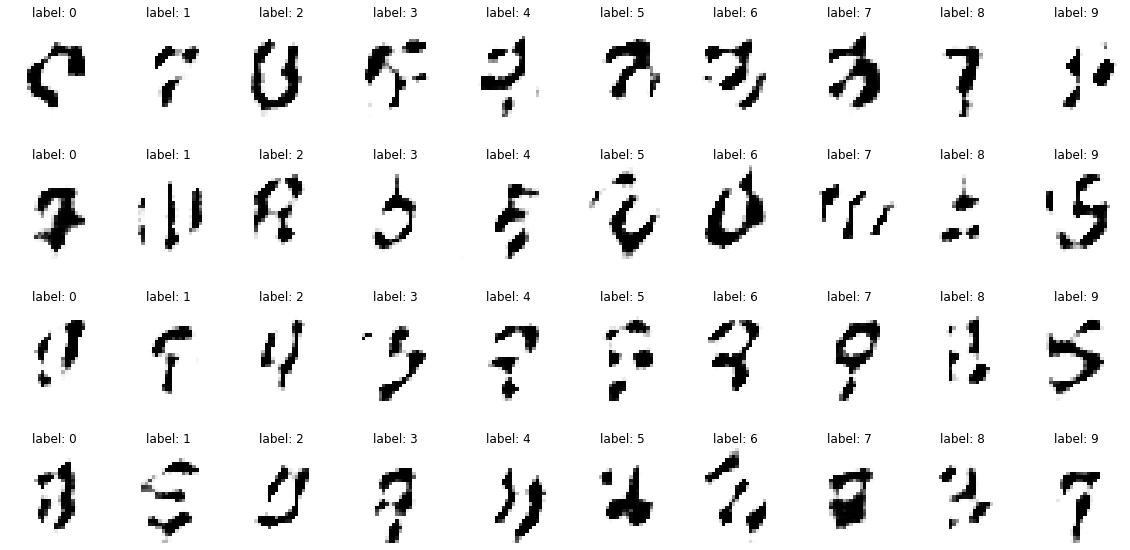

Epoch: >2, Batch: 546/546, Dis_loss=0.474, Dis_accuracy=0.906 Gen_loss=0.921


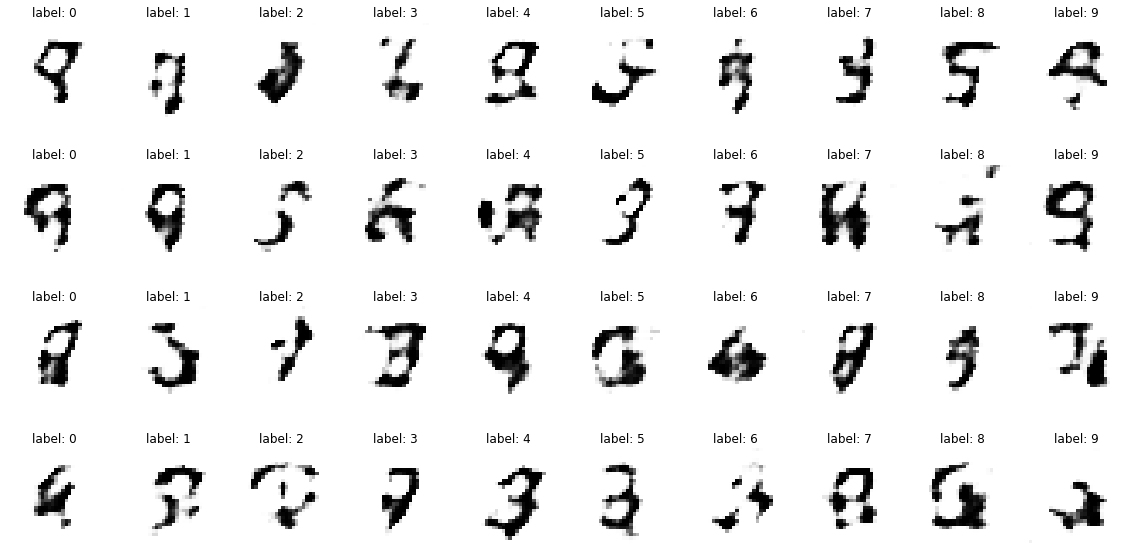

Epoch: >3, Batch: 546/546, Dis_loss=0.604, Dis_accuracy=0.781 Gen_loss=0.754
Epoch: >4, Batch: 546/546, Dis_loss=0.629, Dis_accuracy=0.680 Gen_loss=0.928
Epoch: >5, Batch: 546/546, Dis_loss=0.498, Dis_accuracy=0.820 Gen_loss=0.785
Epoch: >6, Batch: 546/546, Dis_loss=0.570, Dis_accuracy=0.695 Gen_loss=1.116
Epoch: >7, Batch: 546/546, Dis_loss=0.649, Dis_accuracy=0.625 Gen_loss=0.778
Epoch: >8, Batch: 546/546, Dis_loss=0.481, Dis_accuracy=0.836 Gen_loss=0.925
Epoch: >9, Batch: 546/546, Dis_loss=0.544, Dis_accuracy=0.727 Gen_loss=0.786
Epoch: >10, Batch: 546/546, Dis_loss=0.578, Dis_accuracy=0.719 Gen_loss=0.936
Epoch: >11, Batch: 546/546, Dis_loss=0.603, Dis_accuracy=0.711 Gen_loss=0.849
Epoch: >12, Batch: 546/546, Dis_loss=0.588, Dis_accuracy=0.617 Gen_loss=0.794
Epoch: >13, Batch: 546/546, Dis_loss=0.671, Dis_accuracy=0.633 Gen_loss=0.877
Epoch: >14, Batch: 546/546, Dis_loss=0.623, Dis_accuracy=0.648 Gen_loss=0.794
Epoch: >15, Batch: 546/546, Dis_loss=0.608, Dis_accuracy=0.656 Gen_loss

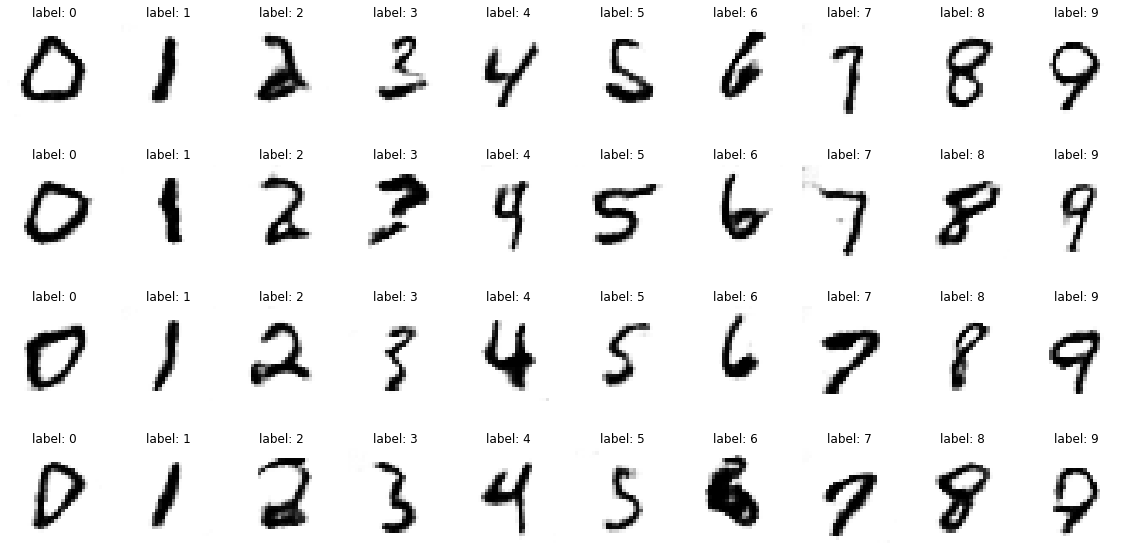

Epoch: >21, Batch: 546/546, Dis_loss=0.613, Dis_accuracy=0.625 Gen_loss=1.229
Epoch: >22, Batch: 546/546, Dis_loss=0.552, Dis_accuracy=0.734 Gen_loss=1.288
Epoch: >23, Batch: 546/546, Dis_loss=0.597, Dis_accuracy=0.680 Gen_loss=1.127
Epoch: >24, Batch: 546/546, Dis_loss=0.516, Dis_accuracy=0.781 Gen_loss=0.901
Epoch: >25, Batch: 546/546, Dis_loss=0.592, Dis_accuracy=0.719 Gen_loss=1.077
Epoch: >26, Batch: 546/546, Dis_loss=0.552, Dis_accuracy=0.695 Gen_loss=1.149
Epoch: >27, Batch: 546/546, Dis_loss=0.510, Dis_accuracy=0.781 Gen_loss=1.245
Epoch: >28, Batch: 546/546, Dis_loss=0.582, Dis_accuracy=0.688 Gen_loss=1.221
Epoch: >29, Batch: 546/546, Dis_loss=0.645, Dis_accuracy=0.602 Gen_loss=1.529
Epoch: >30, Batch: 546/546, Dis_loss=0.659, Dis_accuracy=0.641 Gen_loss=0.736
Epoch: >31, Batch: 546/546, Dis_loss=0.628, Dis_accuracy=0.594 Gen_loss=0.917
Epoch: >32, Batch: 546/546, Dis_loss=0.591, Dis_accuracy=0.711 Gen_loss=0.858
Epoch: >33, Batch: 546/546, Dis_loss=0.560, Dis_accuracy=0.695 G

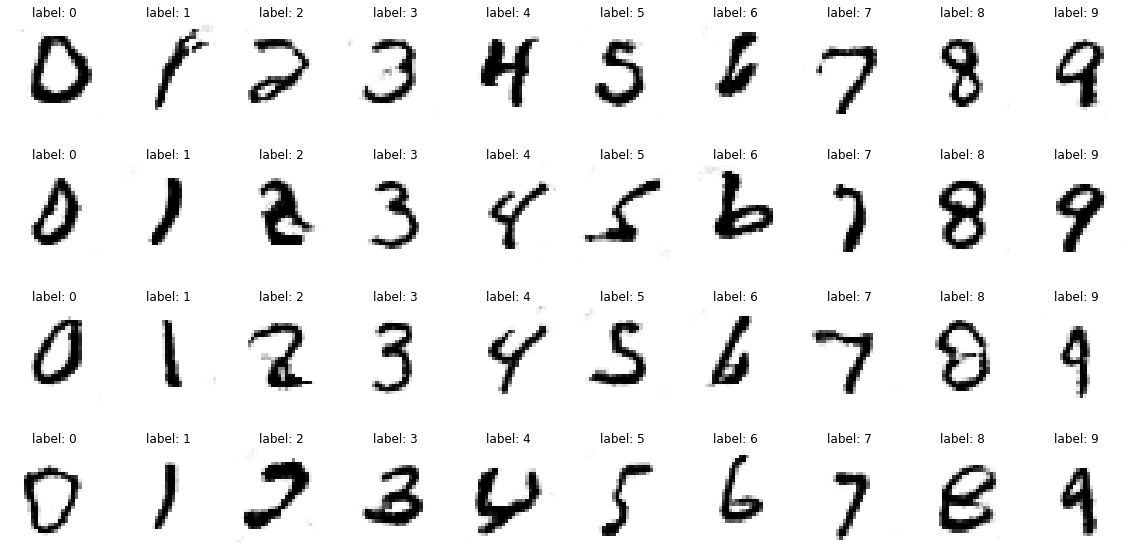

Epoch: >41, Batch: 546/546, Dis_loss=0.585, Dis_accuracy=0.648 Gen_loss=0.870
Epoch: >42, Batch: 546/546, Dis_loss=0.521, Dis_accuracy=0.742 Gen_loss=1.057
Epoch: >43, Batch: 546/546, Dis_loss=0.601, Dis_accuracy=0.672 Gen_loss=0.981
Epoch: >44, Batch: 546/546, Dis_loss=0.623, Dis_accuracy=0.633 Gen_loss=0.777
Epoch: >45, Batch: 546/546, Dis_loss=0.555, Dis_accuracy=0.711 Gen_loss=0.800
Epoch: >46, Batch: 546/546, Dis_loss=0.606, Dis_accuracy=0.695 Gen_loss=0.897
Epoch: >47, Batch: 546/546, Dis_loss=0.551, Dis_accuracy=0.695 Gen_loss=1.047
Epoch: >48, Batch: 546/546, Dis_loss=0.643, Dis_accuracy=0.633 Gen_loss=1.130
Epoch: >49, Batch: 546/546, Dis_loss=0.687, Dis_accuracy=0.633 Gen_loss=1.067
Epoch: >50, Batch: 546/546, Dis_loss=0.644, Dis_accuracy=0.633 Gen_loss=0.853
Epoch: >51, Batch: 546/546, Dis_loss=0.574, Dis_accuracy=0.719 Gen_loss=0.907
Epoch: >52, Batch: 546/546, Dis_loss=0.672, Dis_accuracy=0.578 Gen_loss=0.667
Epoch: >53, Batch: 546/546, Dis_loss=0.638, Dis_accuracy=0.633 G

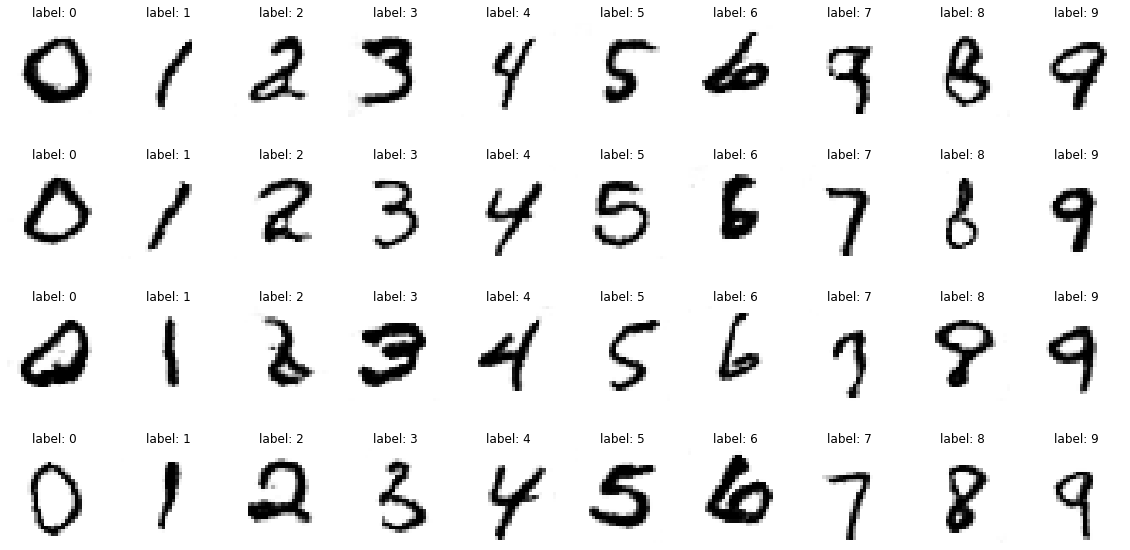

Epoch: >61, Batch: 546/546, Dis_loss=0.639, Dis_accuracy=0.656 Gen_loss=1.079
Epoch: >62, Batch: 546/546, Dis_loss=0.613, Dis_accuracy=0.633 Gen_loss=1.148
Epoch: >63, Batch: 546/546, Dis_loss=0.523, Dis_accuracy=0.773 Gen_loss=1.002
Epoch: >64, Batch: 546/546, Dis_loss=0.640, Dis_accuracy=0.633 Gen_loss=0.858
Epoch: >65, Batch: 546/546, Dis_loss=0.535, Dis_accuracy=0.711 Gen_loss=1.014
Epoch: >66, Batch: 546/546, Dis_loss=0.607, Dis_accuracy=0.656 Gen_loss=1.101
Epoch: >67, Batch: 546/546, Dis_loss=0.645, Dis_accuracy=0.578 Gen_loss=1.383
Epoch: >68, Batch: 546/546, Dis_loss=0.584, Dis_accuracy=0.656 Gen_loss=0.636
Epoch: >69, Batch: 546/546, Dis_loss=0.588, Dis_accuracy=0.664 Gen_loss=0.808
Epoch: >70, Batch: 546/546, Dis_loss=0.611, Dis_accuracy=0.641 Gen_loss=0.725
Epoch: >71, Batch: 546/546, Dis_loss=0.600, Dis_accuracy=0.672 Gen_loss=1.471
Epoch: >72, Batch: 546/546, Dis_loss=0.572, Dis_accuracy=0.617 Gen_loss=0.901
Epoch: >73, Batch: 546/546, Dis_loss=0.633, Dis_accuracy=0.648 G

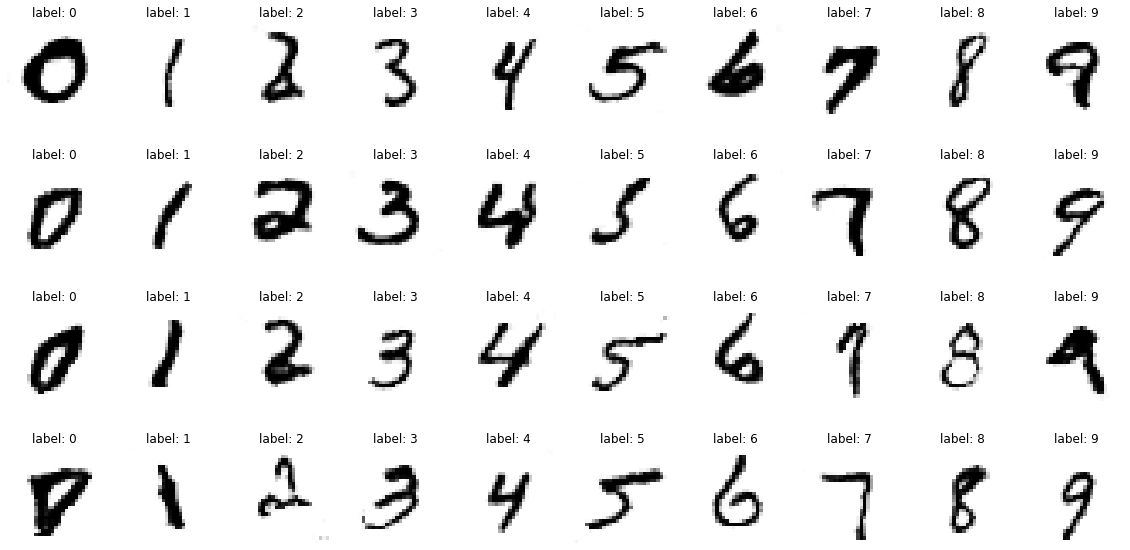

Epoch: >81, Batch: 546/546, Dis_loss=0.632, Dis_accuracy=0.633 Gen_loss=0.775
Epoch: >82, Batch: 546/546, Dis_loss=0.531, Dis_accuracy=0.727 Gen_loss=0.938
Epoch: >83, Batch: 546/546, Dis_loss=0.583, Dis_accuracy=0.656 Gen_loss=0.995
Epoch: >84, Batch: 546/546, Dis_loss=0.607, Dis_accuracy=0.625 Gen_loss=0.998
Epoch: >85, Batch: 546/546, Dis_loss=0.677, Dis_accuracy=0.609 Gen_loss=1.188
Epoch: >86, Batch: 546/546, Dis_loss=0.600, Dis_accuracy=0.672 Gen_loss=1.110
Epoch: >87, Batch: 546/546, Dis_loss=0.620, Dis_accuracy=0.570 Gen_loss=0.930
Epoch: >88, Batch: 546/546, Dis_loss=0.626, Dis_accuracy=0.656 Gen_loss=1.099
Epoch: >89, Batch: 546/546, Dis_loss=0.633, Dis_accuracy=0.602 Gen_loss=0.869
Epoch: >90, Batch: 546/546, Dis_loss=0.539, Dis_accuracy=0.766 Gen_loss=0.778
Epoch: >91, Batch: 546/546, Dis_loss=0.535, Dis_accuracy=0.734 Gen_loss=0.881
Epoch: >92, Batch: 546/546, Dis_loss=0.603, Dis_accuracy=0.633 Gen_loss=1.026
Epoch: >93, Batch: 546/546, Dis_loss=0.581, Dis_accuracy=0.672 G

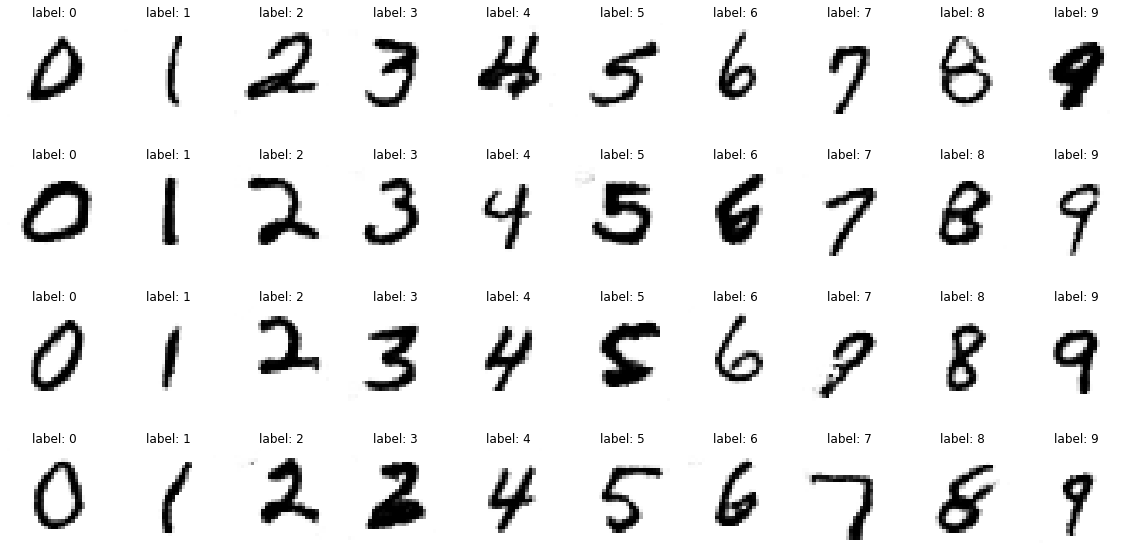

In [22]:
ъlatent_dim = 100
generator_model = create_generator()
discriminator_model = create_discriminator()
gan_model = create_gan(generator_model, discriminator_model)
mnist = tf.keras.datasets.mnist
dataset = load_real_data(mnist)
train(generator_model, discriminator_model, gan_model, dataset, latent_dim, 100)
